# Synthetic IMM, notebook extension, multi‑state Δψ–ΔpH model with CoQ redox pool and cardiolipin‑dependent supercomplex kinetics

This notebook extends the previous syn‑IMM simulator by adding three explicit state variables:

1. **Δψ (mV)** and **ΔpH (pH units)** as separate components of the proton motive force (Δp).
   Δp is computed as **Δp ≈ Δψ + 60·ΔpH (mV)**, using the Nernst conversion commonly used in mitochondrial bioenergetics. Typical ranges are summarized in Perry et al., 2011. https://doi.org/10.2144/000113610  

2. **CoQ redox pool dynamics**, tracking the **QH2 fraction** of the total CoQ pool in the membrane.
   CoQ pool sizes vary by tissue, example nmol CoQ per mg protein values are provided by Burger et al., 2020. https://doi.org/10.1016/j.freeradbiomed.2019.11.028   

3. **Supercomplex assembly fraction S(t)** (0–1) as a kinetic state, with **k_on** increasing with cardiolipin and **k_off** decreasing with cardiolipin, consistent with cardiolipin’s requirement for, or strong promotion of, supercomplex organization. https://doi.org/10.1074/jbc.C200551200  

The code is purely computational and intended for hypothesis testing, sensitivity analysis, and figure generation.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(11)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def clip(x, lo, hi):
    return np.minimum(np.maximum(x, lo), hi)


## 1) Model equations

### Proton motive force
We compute an electrical‑equivalent Δp (mV) as:
- **Δp_mV = Δψ_mV + 60·ΔpH**, using a 60 mV per pH unit Nernst factor approximation.

Typical physiological ranges:
- Δψ ~150–180 mV and ΔpH ~0.5–1.0 units, contributing ~30–60 mV to Δp.

### CoQ pool
State variable:
- `qh2` = fraction of the CoQ pool in reduced form (QH2), 0–1.
We treat **CoQ_total (nmol/mg protein)** as a tunable parameter anchored to measured pools.

### Supercomplex assembly S
State variable:
- `S` = fraction of respiratory chain existing as supercomplex, 0–1.
Assembly kinetics:
- dS/dt = k_on(CL, qh2)·(1−S) − k_off(CL)·S

S then modulates effective electron transfer.


In [5]:
# Cardiolipin dependence helpers
def cl_factor(cl_frac, cl_opt=0.18, width=0.10):
    """Unimodal factor peaked at cl_opt."""
    return np.exp(-0.5*((cl_frac-cl_opt)/width)**2)

def supercomplex_rates(cl_frac, k_on0=0.20, k_off0=0.10, cl_opt=0.18, width=0.10):
    """Return (k_on, k_off) in 1/min with cardiolipin dependence."""
    f = cl_factor(cl_frac, cl_opt=cl_opt, width=width)
    k_on = k_on0*(0.2 + 0.8*f)
    k_off = k_off0*(1.4 - 0.9*f)   # higher CL -> lower off rate
    return float(k_on), float(max(1e-6, k_off))

def atp_flux_from_dp(dp_mV, Vmax, dp_half=160.0, hill=3.0):
    """Steep Δp dependence for ATP synthase."""
    x = (dp_mV - dp_half)/18.0
    return Vmax*(sigmoid(x)**hill)

def leak_flux_psi(psi_mV, g_leak, psi_ref=150.0):
    """Empirical leak scaling with Δψ."""
    return g_leak*(psi_mV/psi_ref)**1.5

def leak_flux_pH(dpH, g_pH_leak, dpH_ref=0.7):
    """Empirical dissipation of ΔpH."""
    return g_pH_leak*(dpH/dpH_ref)**1.3


## 2) Parameters (benchmarked ranges)

We use benchmarks to set *order‑of‑magnitude* values:
- CoQ pools, example nmol/mg protein values in Burger et al., 2020.
- Typical Δψ, ΔpH ranges and Nernst conversion in Perry et al., 2011.
- Cardiolipin dependence of supercomplex formation in Zhang et al., 2002 and Bazán et al., 2013.

All parameters are exposed for sensitivity analysis.

In [8]:
params = dict(
    # Lipid composition
    cl_frac=0.18,
    cl_opt=0.18,
    cl_width=0.10,

    # CoQ pool (nmol/mg protein) and redox kinetics
    CoQ_total=1.0,          # nmol/mg (within tissue-scale orders) 
    k_red_base=2.5,         # 1/min, effective CoQ reduction kinetics
    k_ox_base=3.2,          # 1/min, effective CoQ oxidation kinetics
    qh2_init=0.30,

    # Electron throughput capacity (nmol e- eq/min/mg)
    J_e_in_max=1400.0,

    # Supercomplex kinetics
    k_on0=0.30,             # 1/min
    k_off0=0.12,            # 1/min
    S_init=0.30,

    # Δψ / ΔpH dynamics
    psi_init=20.0,
    dpH_init=0.10,
    psi_pump_gain=0.020,    # mV per (nmol e- eq/min/mg) per min (lumped)
    pH_pump_gain=0.00080,   # pH units per (nmol e- eq/min/mg) per min (lumped)

    # Leak
    g_leak_psi=3.0,         # mV/min equivalent
    g_leak_pH=0.18,         # pH units/min equivalent

    # ATP synthase
    ATP_Vmax=950.0,         # nmol ATP/min/mg
    dp_half=165.0,          # mV midpoint for Δp dependence
    ATP_hill=3.2,
    dp_cost_per_ATP=0.10,   # mV drain per nmol ATP (lumped)

    # Partition: how ATP synthesis drains Δψ vs ΔpH (0..1)
    frac_cost_to_psi=0.75,

    # Transport limit (optional)
    ANT_cap=3500.0,
    PiC_cap=1800.0,
)
params


{'cl_frac': 0.18,
 'cl_opt': 0.18,
 'cl_width': 0.1,
 'CoQ_total': 1.0,
 'k_red_base': 2.5,
 'k_ox_base': 3.2,
 'qh2_init': 0.3,
 'J_e_in_max': 1400.0,
 'k_on0': 0.3,
 'k_off0': 0.12,
 'S_init': 0.3,
 'psi_init': 20.0,
 'dpH_init': 0.1,
 'psi_pump_gain': 0.02,
 'pH_pump_gain': 0.0008,
 'g_leak_psi': 3.0,
 'g_leak_pH': 0.18,
 'ATP_Vmax': 950.0,
 'dp_half': 165.0,
 'ATP_hill': 3.2,
 'dp_cost_per_ATP': 0.1,
 'frac_cost_to_psi': 0.75,
 'ANT_cap': 3500.0,
 'PiC_cap': 1800.0}

## 3) Simulator

State variables: Δψ, ΔpH, QH2 fraction, and supercomplex fraction S.
Outputs: Δp, ATP synthesis and export, electron throughput, and state trajectories.

In [27]:
def simulate_multistate(p, t_end_min=8.0, dt=0.01, enable_transport=True):
    n = int(t_end_min/dt) + 1
    t = np.linspace(0, t_end_min, n)

    psi = np.zeros(n); dpH = np.zeros(n); dp = np.zeros(n)
    qh2 = np.zeros(n); S = np.zeros(n)
    J_red = np.zeros(n); J_ox = np.zeros(n); J_e = np.zeros(n)
    J_ATP = np.zeros(n); J_exp = np.zeros(n); ATP_ext = np.zeros(n)

    psi[0] = p["psi_init"]
    dpH[0] = p["dpH_init"]
    qh2[0] = p["qh2_init"]
    S[0] = p["S_init"]

    for i in range(1, n):
        # Cardiolipin factor
        f_cl = float(cl_factor(p["cl_frac"], p["cl_opt"], p["cl_width"]))

        # Supercomplex kinetics
        k_on, k_off = supercomplex_rates(
            p["cl_frac"], p["k_on0"], p["k_off0"], cl_opt=p["cl_opt"], width=p["cl_width"]
        )
        k_on_eff = k_on*(0.85 + 0.30*qh2[i-1])  # mild redox modulation
        dS = k_on_eff*(1 - S[i-1]) - k_off*S[i-1]
        S[i] = clip(S[i-1] + dS*dt, 0.0, 1.0)

        # CoQ redox kinetics
        k_red = p["k_red_base"]*(0.6 + 0.8*f_cl)
        k_ox  = p["k_ox_base"]*(0.6 + 0.9*S[i])

        J_red_i = (p["J_e_in_max"] * (1 - qh2[i-1])) * (k_red/(k_red+1.0))
        J_ox_i  = (p["J_e_in_max"] * (qh2[i-1]))      * (k_ox /(k_ox +1.0))

        dq = (J_red_i - J_ox_i) * dt / max(1e-9, p["CoQ_total"])
        qh2[i] = clip(qh2[i-1] + dq, 0.0, 1.0)

        J_red[i] = J_red_i
        J_ox[i] = J_ox_i
        J_e[i] = min(J_red_i, J_ox_i)

        # Δp
        dp[i-1] = psi[i-1] + 60.0*dpH[i-1]

        # ATP synthesis and export
        J_ATP_i = atp_flux_from_dp(dp[i-1], p["ATP_Vmax"], p["dp_half"], p["ATP_hill"])
        J_ATP[i] = J_ATP_i

        if enable_transport:
            J_exp_i = min(p["ANT_cap"], p["PiC_cap"], J_ATP_i)
        else:
            J_exp_i = 0.0
        J_exp[i] = J_exp_i
        ATP_ext[i] = ATP_ext[i-1] + J_exp_i*dt

        # Pumping gains
        pump_gain = (1.0 + 0.35*S[i])*(0.75 + 0.45*f_cl)
        dpsi_pump = p["psi_pump_gain"]*pump_gain*J_e[i]
        dpH_pump  = p["pH_pump_gain"] *pump_gain*J_e[i]

        # ATP back-action cost on Δp, partitioned
        dp_cost = p["dp_cost_per_ATP"]*J_ATP_i
        dpsi_cost = p["frac_cost_to_psi"]*dp_cost
        dpH_cost  = (1-p["frac_cost_to_psi"])*dp_cost/60.0

        # Leak drains ψ and pH
        dpsi_leak = leak_flux_psi(psi[i-1], p["g_leak_psi"])
        dpH_leak  = leak_flux_pH(dpH[i-1], p["g_leak_pH"])

        # Integrate
        psi[i] = max(0.0, psi[i-1] + (dpsi_pump - dpsi_cost - dpsi_leak)*dt)
        dpH[i] = max(0.0, dpH[i-1] + (dpH_pump  - dpH_cost  - dpH_leak )*dt)

    dp[-1] = psi[-1] + 60.0*dpH[-1]

    return pd.DataFrame({
        "t_min": t,
        "psi_mV": psi,
        "dpH": dpH,
        "dp_mV": dp,
        "qh2_frac": qh2,
        "S_supercomplex": S,
        "J_red": J_red,
        "J_ox": J_ox,
        "J_e": J_e,
        "J_ATP": J_ATP,
        "J_export": J_exp,
        "ATP_ext": ATP_ext
    })

# Baseline run
base = simulate_multistate(params, t_end_min=8.0, dt=0.01, enable_transport=True)
# base.tail(2)
base

,t_min,psi_mV,dpH,dp_mV,qh2_frac,S_supercomplex,J_red,J_ox,J_e,J_ATP,J_export,ATP_ext
0,0.00,20.000000,0.100000,26.000000,0.3,0.300000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.01,20.080575,0.103138,26.268853,1.0,0.301794,762.222222,309.157688,309.157688,1.758770e-08,1.758770e-08,1.758770e-10
2,0.02,20.079105,0.102989,26.258425,0.0,0.304022,0.000000,1031.150169,0.000000,1.844834e-08,1.844834e-08,3.603604e-10
3,0.03,20.077636,0.102840,26.248014,1.0,0.305614,1088.888889,0.000000,0.000000,1.841419e-08,1.841419e-08,5.445024e-10
4,0.04,20.076167,0.102691,26.237620,0.0,0.307826,0.000000,1032.211913,0.000000,1.838016e-08,1.838016e-08,7.283039e-10
...,...,...,...,...,...,...,...,...,...,...,...,...
796,7.96,18.961384,0.038349,21.262318,0.0,0.803170,0.000000,1132.473700,0.000000,7.583337e-09,7.583337e-09,9.040135e-08
797,7.97,18.960035,0.038308,21.258494,1.0,0.803190,1088.888889,0.000000,0.000000,7.578180e-09,7.578180e-09,9.047713e-08
798,7.98,18.958687,0.038266,21.254674,0.0,0.803387,0.000000,1132.505659,0.000000,7.573032e-09,7.573032e-09,9.055286e-08
799,7.99,18.957339,0.038225,21.250857,1.0,0.803407,1088.888889,0.000000,0.000000,7.567892e-09,7.567892e-09,9.062854e-08


## 4) Baseline plots, Δψ vs ΔpH, CoQ redox, and supercomplex state

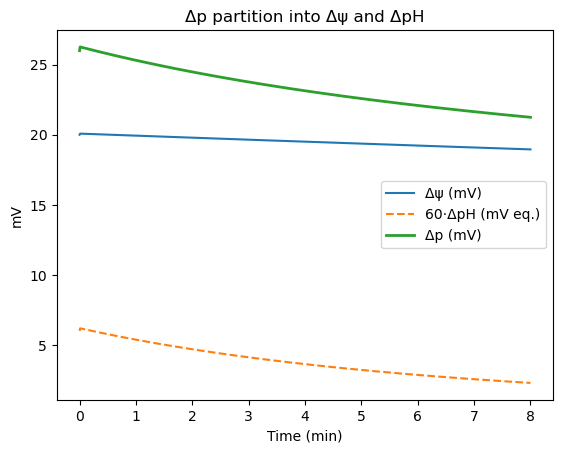

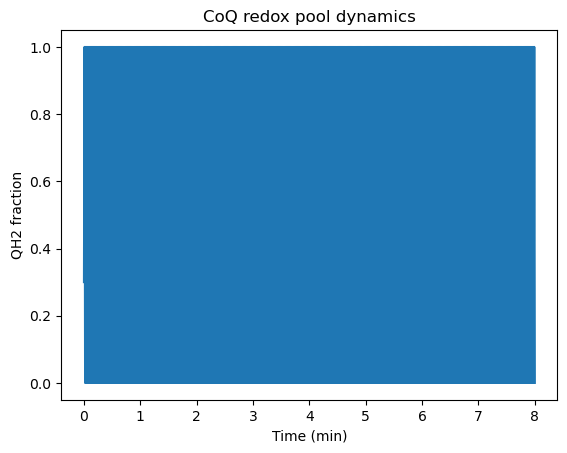

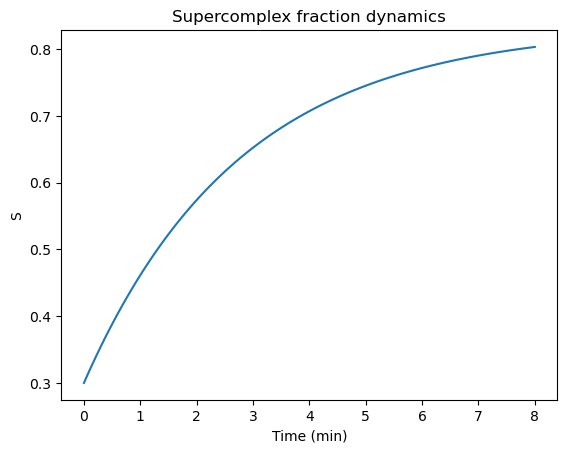

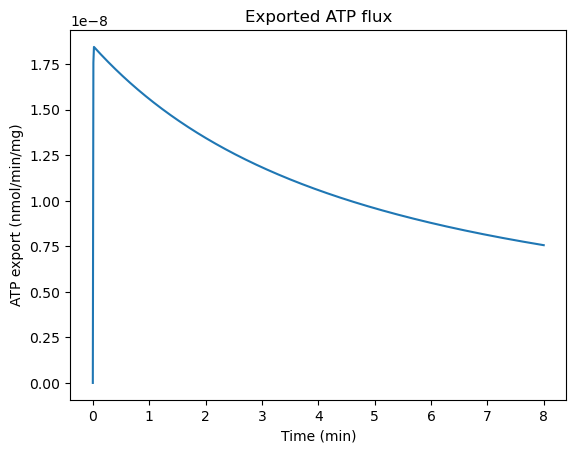

In [14]:
plt.figure()
plt.plot(base["t_min"], base["psi_mV"], label="Δψ (mV)")
plt.plot(base["t_min"], 60*base["dpH"], label="60·ΔpH (mV eq.)", linestyle="--")
plt.plot(base["t_min"], base["dp_mV"], label="Δp (mV)", linewidth=2)
plt.xlabel("Time (min)")
plt.ylabel("mV")
plt.title("Δp partition into Δψ and ΔpH")
plt.legend()
plt.show()

plt.figure()
plt.plot(base["t_min"], base["qh2_frac"])
plt.xlabel("Time (min)")
plt.ylabel("QH2 fraction")
plt.title("CoQ redox pool dynamics")
plt.show()

plt.figure()
plt.plot(base["t_min"], base["S_supercomplex"])
plt.xlabel("Time (min)")
plt.ylabel("S")
plt.title("Supercomplex fraction dynamics")
plt.show()

plt.figure()
plt.plot(base["t_min"], base["J_export"])
plt.xlabel("Time (min)")
plt.ylabel("ATP export (nmol/min/mg)")
plt.title("Exported ATP flux")
plt.show()


## 5) Perturbation panel

In [17]:
def run_scenario(name, **overrides):
    p = params.copy()
    p.update(overrides)
    df = simulate_multistate(p, t_end_min=8.0, dt=0.01, enable_transport=True)
    df["scenario"] = name
    return df

pert = pd.concat([
    run_scenario("Baseline"),
    run_scenario("Low CL (5%)", cl_frac=0.05),
    run_scenario("High CL (30%)", cl_frac=0.30),
    run_scenario("High leak", g_leak_psi=7.0, g_leak_pH=0.40),
    run_scenario("Low CoQ pool", CoQ_total=0.25),
    run_scenario("High CoQ pool", CoQ_total=2.0),
    run_scenario("Weak supercomplex assembly", k_on0=0.08),
    run_scenario("Strong supercomplex assembly", k_on0=0.60, k_off0=0.06),
], ignore_index=True)

end = pert.groupby("scenario").tail(1).set_index("scenario")[["psi_mV","dpH","dp_mV","qh2_frac","S_supercomplex","J_export","ATP_ext"]]
end


,psi_mV,dpH,dp_mV,qh2_frac,S_supercomplex,J_export,ATP_ext
scenario,,,,,,,
Baseline,18.955991,0.038184,21.247044,0.0,0.803603,7.562761e-09,9.070417e-08
Low CL (5%),18.939858,0.037991,21.219300,0.0,0.545036,7.525539e-09,9.002776e-08
High CL (30%),18.941474,0.038010,21.222081,0.0,0.575752,7.529262e-09,9.009531e-08
High leak,17.596012,0.015294,18.513659,0.0,0.803603,4.653285e-09,6.620399e-08
Low CoQ pool,18.955991,0.038184,21.247044,0.0,0.803603,7.562761e-09,9.070417e-08
High CoQ pool,18.955991,0.038184,21.247044,0.0,0.803603,7.562761e-09,9.070417e-08
Weak supercomplex assembly,18.955927,0.038183,21.246934,0.0,0.482972,7.562612e-09,9.070147e-08
Strong supercomplex assembly,18.956083,0.038185,21.247201,0.0,0.948253,7.562972e-09,9.070802e-08


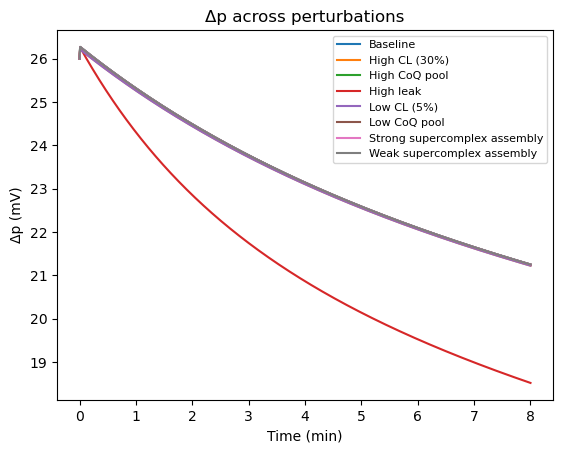

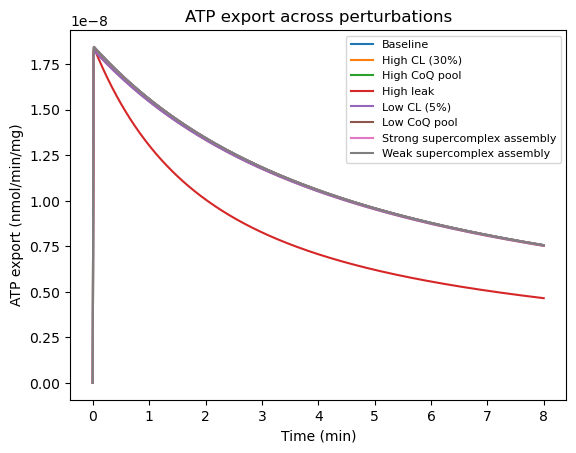

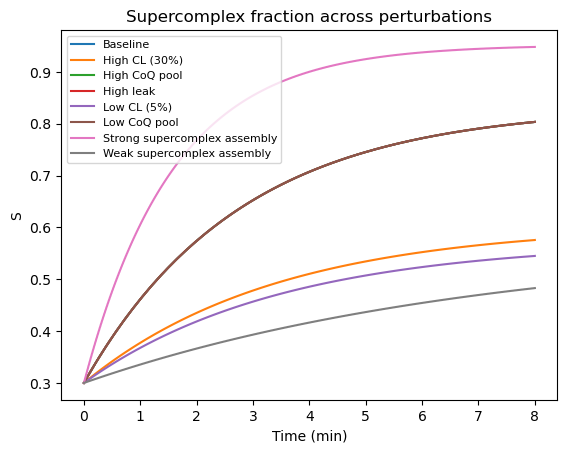

In [19]:
plt.figure()
for s, df in pert.groupby("scenario"):
    plt.plot(df["t_min"], df["dp_mV"], label=s)
plt.xlabel("Time (min)")
plt.ylabel("Δp (mV)")
plt.title("Δp across perturbations")
plt.legend(fontsize=8)
plt.show()

plt.figure()
for s, df in pert.groupby("scenario"):
    plt.plot(df["t_min"], df["J_export"], label=s)
plt.xlabel("Time (min)")
plt.ylabel("ATP export (nmol/min/mg)")
plt.title("ATP export across perturbations")
plt.legend(fontsize=8)
plt.show()

plt.figure()
for s, df in pert.groupby("scenario"):
    plt.plot(df["t_min"], df["S_supercomplex"], label=s)
plt.xlabel("Time (min)")
plt.ylabel("S")
plt.title("Supercomplex fraction across perturbations")
plt.legend(fontsize=8)
plt.show()


## 6) Heatmap, cardiolipin × leak

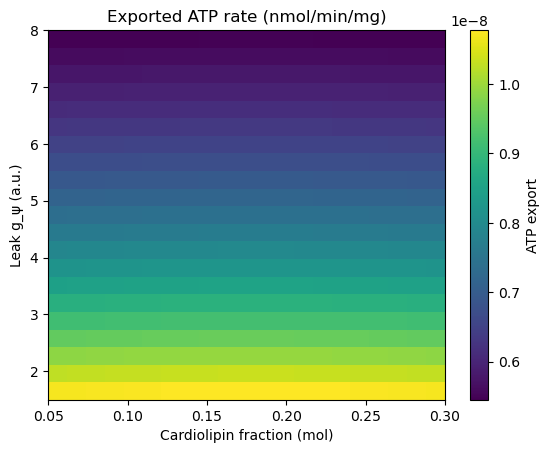

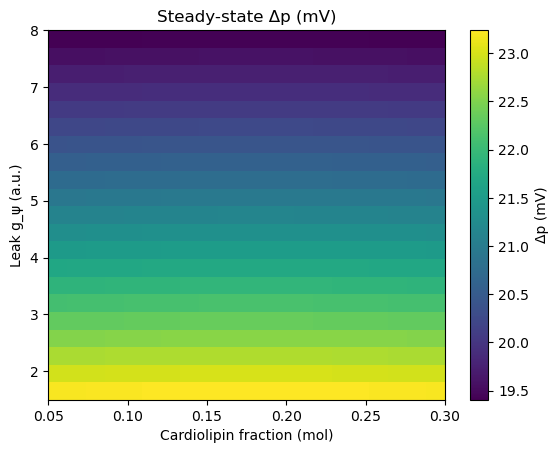

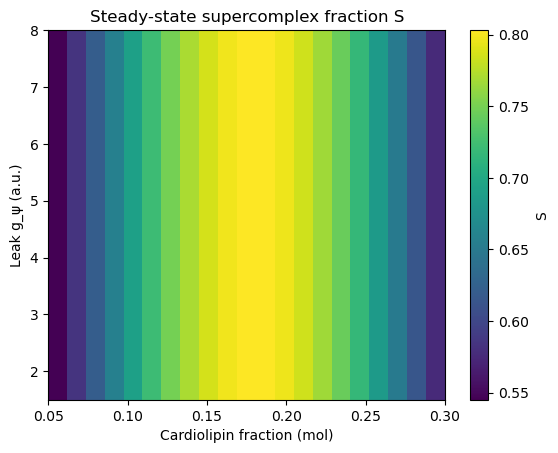

In [22]:
cl_vals = np.linspace(0.05, 0.30, 21)
leak_vals = np.linspace(1.5, 8.0, 21)

ATP_heat = np.zeros((len(leak_vals), len(cl_vals)))
dp_heat  = np.zeros_like(ATP_heat)
S_heat   = np.zeros_like(ATP_heat)

for i, lg in enumerate(leak_vals):
    for j, cl in enumerate(cl_vals):
        p = params.copy()
        p["cl_frac"] = float(cl)
        p["g_leak_psi"] = float(lg)
        p["g_leak_pH"] = float(0.06 + 0.05*(lg/3.0))
        df = simulate_multistate(p, t_end_min=8.0, dt=0.01, enable_transport=True)
        last = df.iloc[-1]
        ATP_heat[i,j] = last["J_export"]
        dp_heat[i,j]  = last["dp_mV"]
        S_heat[i,j]   = last["S_supercomplex"]

plt.figure()
plt.imshow(ATP_heat, aspect="auto", origin="lower",
           extent=[cl_vals.min(), cl_vals.max(), leak_vals.min(), leak_vals.max()])
plt.xlabel("Cardiolipin fraction (mol)")
plt.ylabel("Leak g_ψ (a.u.)")
plt.title("Exported ATP rate (nmol/min/mg)")
plt.colorbar(label="ATP export")
plt.show()

plt.figure()
plt.imshow(dp_heat, aspect="auto", origin="lower",
           extent=[cl_vals.min(), cl_vals.max(), leak_vals.min(), leak_vals.max()])
plt.xlabel("Cardiolipin fraction (mol)")
plt.ylabel("Leak g_ψ (a.u.)")
plt.title("Steady-state Δp (mV)")
plt.colorbar(label="Δp (mV)")
plt.show()

plt.figure()
plt.imshow(S_heat, aspect="auto", origin="lower",
           extent=[cl_vals.min(), cl_vals.max(), leak_vals.min(), leak_vals.max()])
plt.xlabel("Cardiolipin fraction (mol)")
plt.ylabel("Leak g_ψ (a.u.)")
plt.title("Steady-state supercomplex fraction S")
plt.colorbar(label="S")
plt.show()


## 7) Rationale recap

**Separating Δψ and ΔpH** lets you test whether changes in coupling primarily affect electrical potential or the pH gradient.

**Explicit CoQ redox** introduces kinetic buffering and saturation, rather than assuming an infinite carrier pool.

**Supercomplex kinetics S(t)** makes organization dynamic and cardiolipin-dependent, enabling recovery and perturbation experiments in silico.